<h1>Basic Template For All NN</h1>

In [17]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from keras.applications import MobileNet
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

<h2>Data Loading and Preparation</h2>

In [23]:
def getEmotionCode(x):
    part = x.split('_')
    if part[2] == 'SAD':
        return 0
    elif part[2] == 'ANG':
        return 1
    elif part[2] == 'DIS':
        return 2
    elif part[2] == 'FEA':
        return 3
    elif part[2] == 'HAP':
        return 4
    elif part[2] == 'NEU':
        return 5
    else:
        return 'Unknown'
    
def getEmotion(x):
    if x == 0:
        return 'SAD'
    elif x == 1:
        return 'ANG'
    elif x == 2:
        return 'DIS'
    elif x == 3:
        return 'FEA'
    elif x == 4:
        return 'HAP'
    elif x == 5:
        return 'NEU'
    else:
        return 'Unknown'

In [22]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    #Specific to MobileNetV2
    spectrogram = spectrogram.resize((224,224))
    spectrogram = np.array(spectrogram)
    X_all.append(spectrogram)
    Y_all.append(getEmotionCode(file_name))
    
print(X_all)
print(Y_all)
plt.imshow(X_all[0])


[]
[]


IndexError: list index out of range

In [4]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=6)

print(X_all)
print(Y_all)

(3512, 224, 224, 3)
(3512,)
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.

In [5]:
# Default 75/25% split
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, random_state = 123)



<h2>Model Building</h2>

In [6]:
def build_current_model():
    base_model = MobileNet(include_top=False, weights='imagenet', pooling='avg', alpha=.25, input_shape=(224,224,3), depth_multiplier=1, dropout=.2)

    for layer in base_model.layers: # here we freeze the layers from mobilenet
        layer.trainable=False

    x_top = base_model.output
    x_dense = Dense(10, activation='relu')(x_top)
    x_out = Dense(6, name='output', activation='softmax')(x_dense)
    model = Model(base_model.input, x_out)
    model.summary()

    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

model = build_current_model()

2113536/2108140 [==============================] - 18s 8us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 8)       216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 8)       32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 8)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 8)       72        
_____________________________________________________________

<h2>Basic/Fast Training and Evaluation</h2>

In [7]:
history = model.fit(X_train, Y_train, 
              epochs=10, 
              validation_split=0.1, 
              verbose=1, batch_size=32)

history_info = history.history

Train on 2634 samples, validate on 878 samples
Epoch 1/10
2634/2634 [==============================] - 56s 21ms/step - loss: 1.7800 - accuracy: 0.2251 - val_loss: 1.7767 - val_accuracy: 0.1788
Epoch 2/10
2634/2634 [==============================] - 53s 20ms/step - loss: 1.7288 - accuracy: 0.2585 - val_loss: 1.7750 - val_accuracy: 0.1617
Epoch 3/10
2634/2634 [==============================] - 56s 21ms/step - loss: 1.6930 - accuracy: 0.2680 - val_loss: 1.7456 - val_accuracy: 0.2005
Epoch 4/10
2634/2634 [==============================] - 58s 22ms/step - loss: 1.6698 - accuracy: 0.2733 - val_loss: 1.7301 - val_accuracy: 0.2323
Epoch 5/10
2634/2634 [==============================] - 54s 21ms/step - loss: 1.6502 - accuracy: 0.2809 - val_loss: 1.7291 - val_accuracy: 0.2289
Epoch 6/10
2634/2634 [==============================] - 53s 20ms/step - loss: 1.6329 - accuracy: 0.2775 - val_loss: 1.7207 - val_accuracy: 0.2358
Epoch 7/10
2634/2634 [==============================] - 50s 19ms/step - loss:

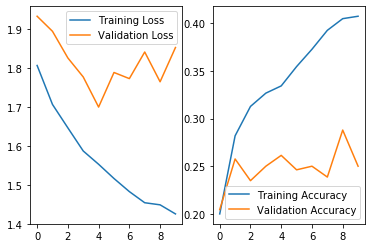

In [11]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)


sns.lineplot(data=history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=history_info['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=history_info['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [19]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [20]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(actual,predicted)
print(cm)

NameError: name 'X_test' is not defined

In [ ]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(Y_test, Y_pred))


In [ ]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual, predicted))

In [ ]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

In [ ]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 6
tpr = [0] * 6
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getEmotion(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(6):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 6

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

In [ ]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 6
rec = [0] * 6
for i in range(6):
    prec[i], rec[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(prec[i], rec[i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getEmotion(i) +' (area = ' + str(auc_val) + ')', legend='brief')

# Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

all_precision = list()
all_recall = list()
all_f1 = list()
all_tpr = list()
all_fpr = list()
all_accuracy = list()
all_roc_curve = list()
all_prec_rec_curve = list()


n_split=3
for train_index,test_index in KFold(n_split).split(X_train): #Also consider StratifiedKFold  
    # use the index to generate training an testing sets
    x_train,x_test=X_train[train_index],X_train[test_index]
    y_train,y_test=Y_train[train_index],Y_train[test_index]

    # create and fit the model
    model=build_current_model()
    history = model.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.1,
              verbose=1)
    
    #generate predictions
    y_pred = model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_prec, curr_rec, curr_f1, curr_supp = precision_recall_fscore_support(y_test, y_pred)
    curr_fpr = [0] * 6
    curr_tpr = [0] * 6
    for i in range(6):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_accuracy = accuracy_score(Y_test, Y_pred)
    
    #add to lists
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_f1.append(curr_f1)
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_accuracy.append(curr_accuracy)
    


In [ ]:
## Calculate and report avg/sdev of above metrics, and plot graphs

<h2>Storing/Loading history and model to file</h2>

In [9]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('history.json')

In [11]:
##Save Model
model.save('mobile_net_trained.model') #Save the model

In [18]:
## Load Model
model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model